In [83]:
import numpy as np
import csv
import datetime
import time

In [84]:
def addElement(array, index, ele):
    if array and index < len(array):
        array[index] += ele
        return array
    newArray = [0] * (index + 1)
    if array:
        newArray[:len(array)] = array
    newArray[index] = ele
    return newArray

In [85]:
trafficRecordsById = {}
startTime = 1433142000

with open("new.csv") as f:
    trafficRecords = csv.reader(f, delimiter=',')
    count = 0
    for trafficRecord in trafficRecords:
        if count % 100000 == 0:
            print (count / 24015249 * 100, "%")
#         if count == 30000:
#             break
        recordTime = trafficRecord[1]
        checkPointId = trafficRecord[2]
        lane = int(trafficRecord[3])
        traffic = int(trafficRecord[4])

        relativeTime = time.mktime(datetime.datetime.strptime(recordTime, "%Y-%m-%d %H:%M:%S").timetuple()) - startTime
#         print (relativeTime)
        intervalId = relativeTime // 300
#         print (intervalId)
        
        trafficRecordsForId = trafficRecordsById.get(checkPointId)
        if not trafficRecordsForId:
            trafficByLane = addElement(None, lane, traffic)
            trafficRecordsById[checkPointId] = [(intervalId, trafficByLane)]
        else:
            prevIntervalId = trafficRecordsForId[-1][0]
            prevTrafficByLane = trafficRecordsForId[-1][1]
            if (intervalId == prevIntervalId):
                trafficRecordsForId[-1] = (intervalId, addElement(prevTrafficByLane, lane, traffic))
            else:
                trafficRecordsForId.append((intervalId, addElement(None, lane, traffic)))
        count += 1
                

import pickle

pickle.dump(trafficRecordsById, open("trafficRecordsById.p", "wb"))
    

0.0 %
0.4164020951854382 %
0.8328041903708764 %
1.2492062855563146 %
1.6656083807417528 %
2.0820104759271914 %
2.4984125711126293 %
2.914814666298067 %
3.3312167614835055 %
3.747618856668944 %
4.164020951854383 %
4.58042304703982 %
4.9968251422252585 %
5.413227237410697 %
5.829629332596134 %
6.246031427781573 %
6.662433522967011 %
7.07883561815245 %
7.495237713337888 %
7.911639808523326 %
8.328041903708765 %
8.744443998894202 %
9.16084609407964 %
9.57724818926508 %
9.993650284450517 %
10.410052379635955 %
10.826454474821395 %
11.242856570006833 %
11.659258665192269 %
12.075660760377708 %
12.492062855563146 %
12.908464950748586 %
13.324867045934022 %
13.74126914111946 %
14.1576712363049 %
14.574073331490336 %
14.990475426675776 %
15.406877521861215 %
15.823279617046651 %
16.23968171223209 %
16.65608380741753 %
17.072485902602967 %
17.488887997788403 %
17.905290092973843 %
18.32169218815928 %
18.73809428334472 %
19.15449637853016 %
19.570898473715594 %
19.987300568901034 %
20.40370266408

In [86]:
trafficRecordsByIdLoaded = pickle.load(open("trafficRecordsById.p", "rb"))

5294


In [131]:
def checkMissingSpots(checkPointId):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    prevIndex = -1
    for trafficRecord in trafficRecordsForId:
        intervalId = trafficRecord[0]
        if intervalId != prevIndex + 1:
            print (prevIndex, intervalId)
        prevIndex = intervalId

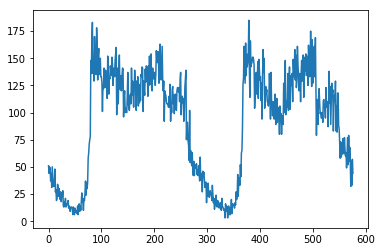

In [97]:
import matplotlib.pyplot as plt
import bisect
def plotTrafficDistribution(checkPointId, timeRange=(None, None), plot=True):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)
    if trafficRecordsForId is None:
        return
    keys = [ele[0] for ele in trafficRecordsForId]
    
    startIntervalId = timeRange[0]
    endIntervalId = timeRange[1]

    startIndex = 0
    endIndex = len(trafficRecordsForId)
    
    if startIntervalId is not None:
        startIndex = bisect.bisect_left(keys, startIntervalId)
    
    if endIntervalId is not None:
        endIndex = bisect.bisect_right(keys, endIntervalId)
        
    if plot:
        x, y = zip(*((ele[0], sum(ele[1])) for ele in trafficRecordsForId[startIndex: endIndex]))

        plt.plot(x, y)
        plt.show()
        
    return trafficRecordsForId[startIndex: endIndex]
    
plotTrafficDistribution("704", (0, 576))    
    

In [132]:
checkMissingSpots("704")

1260.0 1544.0
2282.0 2286.0
2286.0 2289.0
2291.0 2293.0
2294.0 2298.0
2300.0 2303.0
2303.0 2311.0
2311.0 2313.0
2314.0 2321.0
2321.0 2326.0
2326.0 2333.0
2333.0 2335.0
2335.0 2338.0
2338.0 2340.0
2356.0 2358.0
2367.0 2369.0
2380.0 2382.0
2398.0 2400.0
4767.0 4773.0


In [133]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_friedman1
from sklearn.ensemble import GradientBoostingRegressor

ticksAheadToPredict = 1

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def regression(checkPointId):
    trafficRecordsForId = trafficRecordsByIdLoaded.get(checkPointId)

    X = []
    y = []

    for index, trafficRecord in enumerate(trafficRecordsForId):
        if index < 288:
            continue
        if index >= len(trafficRecordsForId) - ticksAheadToPredict:
            break
        intervalId = trafficRecord[0]
        timeInterval = intervalId % 288
        trafficToPredictYesterday = sum(trafficRecordsForId[index - 288 + ticksAheadToPredict][1])
        trafficYesterday = sum(trafficRecordsForId[index - 288][1])
        TrafficMinusOne = sum(trafficRecordsForId[index - 1][1])
        trafficMinusTwo = sum(trafficRecordsForId[index - 2][1])
        trafficMinusThree = sum(trafficRecordsForId[index - 3][1])
        trafficDeltaOne = TrafficMinusOne - trafficMinusTwo
        trafficDeltaTwo = trafficMinusTwo - trafficMinusThree
        y.append(sum(trafficRecordsForId[index + ticksAheadToPredict][1]))
        X.append([
            timeInterval,
            trafficToPredictYesterday, 
            trafficYesterday, 
            TrafficMinusOne, 
            trafficMinusTwo, 
            trafficDeltaOne, 
            trafficDeltaTwo])


    splitPoint = len(trafficRecordsForId) // 10 * 9
    X_train, X_test = X[:splitPoint], X[splitPoint:]
    y_train, y_test = y[:splitPoint], y[splitPoint:]
    est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
        max_depth=3, random_state=0, loss='huber').fit(X_train, y_train)
    print (mape(y_test, est.predict(X_test)))
    
regression("704")


13.7472250501
